In [17]:
import numpy as np
import matplotlib.pyplot as plt
from cmtj import Junction, CVector, AxialDriver, ScalarDriver, Layer

# Junction definition & helper functions

In [18]:
demagTensor = [CVector(0, 0., 0.), CVector(0., 0, 0.), CVector(0., 0., 1)]
dipoleTensor = [CVector(0, 0., 0.), CVector(0., 0, 0.), CVector(0., 0.0, 0)]

TtoAm = 795774.71
surface = 7e-10 * 7e-10

In [19]:
import multiprocessing as mp


def reconstruction_cost_l2(proposal: np.ndarray, target: np.ndarray):
    return np.sum(np.power(target - proposal, 2))


def reconstruction_cost_l1(proposal: np.ndarray, target: np.ndarray):
    return np.sum(np.abs(target - proposal))


def single_simulation(mtj, Hmag, Hmask, anisTop, J, total_time, time_step,
                      theta, phi):
    externalH = CVector(Hmag * np.sin(theta) * np.cos(phi),
                        Hmag * np.sin(theta) * np.sin(phi),
                        Hmag * np.cos(theta) * Hmag)

    axd = AxialDriver([
        ScalarDriver.getConstantDriver(externalH.x),
        ScalarDriver.getConstantDriver(externalH.y),
        ScalarDriver.getConstantDriver(externalH.z)
    ])
    axd.applyMask(Hmask)
    mtj.setLayerExternalFieldDriver("all", axd)
    mtj.setLayerIECDriver("all", ScalarDriver.getConstantDriver(J))
    mtj.setLayerAnisotropyDriver("free",
                                 ScalarDriver.getConstantDriver(anisTop))
    mtj.setLayerAnisotropyDriver("bottom",
                                 ScalarDriver.getConstantDriver(750e3))
    mtj.runSimulation(totalTime=total_time,
                      timeStep=time_step,
                      writeFrequency=time_step,
                      persist=False,
                      log=False,
                      calculateEnergies=False)

    (Rx, Ry, _) = mtj.getMagnetoresistance()
    return Rx, Ry


def simulator(Rx,
              Ry,
              AMR,
              AHE,
              SMR,
              layers,
              J,
              anisTop,
              theta_range: tuple,
              phi_range: tuple,
              theta_steps: int,
              phi_steps: int,
              Hmag: float,
              Hmask: CVector,
              total_time=3e-9,
              time_step=1e-10) -> np.ndarray:

    output_tensor = np.zeros((theta_steps, phi_steps))
    mtj = Junction(layers, "none", [Rx, Rx], [Ry, Ry], [AMR, AMR], [AHE, AHE],
                   [SMR, SMR])
    for t, theta in enumerate(np.linspace(*theta_range, num=theta_steps)):
        for p, phi in enumerate(np.linspace(*phi_range, num=phi_steps)):
            output_tensor[t, p] = sum(
                single_simulation(mtj=mtj,
                                  Hmag=Hmag,
                                  Hmask=Hmask,
                                  anisTop=anisTop,
                                  J=J,
                                  total_time=total_time,
                                  time_step=time_step,
                                  theta=theta,
                                  phi=phi))
    return output_tensor


def cost_func(target,
              Rx,
              Ry,
              AMR,
              AHE,
              SMR,
              layers,
              J,
              anisTop,
              theta_range: tuple,
              phi_range: tuple,
              theta_steps: int,
              phi_steps: int,
              Hmag: float,
              Hmask: CVector,
              total_time=3e-9,
              time_step=1e-10,
              loss_fn=reconstruction_cost_l2) -> np.ndarray:
    out = simulator(Rx, Ry, AMR, AHE, SMR, layers, J, anisTop, theta_range,
                    phi_range, theta_steps, phi_steps, Hmag, Hmask, total_time,
                    time_step)
    return -1 * loss_fn(out, target)

# Ground truth data generation

Text(0, 0.5, 'Theta')

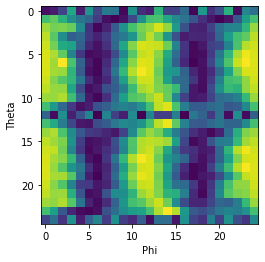

In [4]:
temperature = 300  # room temp
l1 = Layer(id="free",
           mag=CVector(0., 0., 1.),
           anis=CVector(0, 0., 1.),
           Ms=1 * TtoAm,
           thickness=1e-9,
           cellSurface=surface,
           demagTensor=demagTensor,
           dipoleTensor=dipoleTensor,
           temperature=temperature)
l2 = Layer(id="bottom",
           mag=CVector(0., 0., 1.),
           anis=CVector(0, 0., 1.),
           Ms=1 * TtoAm,
           thickness=1e-9,
           cellSurface=surface,
           demagTensor=demagTensor,
           dipoleTensor=dipoleTensor,
           temperature=temperature)

theta_steps = 25
phi_steps = 25
theta_range = (0, 2 * np.pi)
phi_range = (0, 2 * np.pi)
true_params = {
    'Rx': 10,
    'Ry': 0.1,
    'AMR': 0.2,
    'AHE': 0.001,
    'SMR': 0.0034,
    'layers': [l1, l2],
    'theta_range': theta_range,
    'phi_range': phi_range,
    'theta_steps': theta_steps,
    'phi_steps': phi_steps,
    'Hmag': 100 * TtoAm,
    'J': 1e-4,
    'anisTop': 350e3,
    'Hmask': [1, 1, 0]
}
out = simulator(**true_params)
plt.imshow(out)
plt.xlabel("Phi")
plt.ylabel("Theta")

In [9]:
optimizer.max['params']

{'AHE': 0.028497924522275207,
 'AMR': 0.4033076301500014,
 'J': 0.00027747870463259826,
 'Rx': 8.530798129138951,
 'Ry': 0.8722343030115282,
 'SMR': 0.024548489372465163}

In [5]:
np.save("GT1_noise.npy", out)
ground_truth = np.load("GT1_noise.npy")

# Bayes optimisation

In [12]:
from functools import partial

theta_steps = 25
phi_steps = 25
theta_range = (0, 2 * np.pi)
phi_range = (0, 2 * np.pi)

l1 = Layer(id="free",
           mag=CVector(0., 0., 1.),
           anis=CVector(0, 0., 1.),
           Ms=1 * TtoAm,
           thickness=1e-9,
           cellSurface=surface,
           demagTensor=demagTensor,
           dipoleTensor=dipoleTensor,
           temperature=0)
l2 = Layer(id="bottom",
           mag=CVector(0., 0., 1.),
           anis=CVector(0, 0., 1.),
           Ms=1 * TtoAm,
           thickness=1e-9,
           cellSurface=surface,
           demagTensor=demagTensor,
           dipoleTensor=dipoleTensor,
           temperature=0)

pbounds = {
    'Rx': (0.001, 100),
    'Ry': (0.001, 10),
    "AMR": (0, 1),
    "AHE": (0, 0.05),
    "SMR": (0, 0.05),
#     'J': (1e-8, 5e-4),
}
params = {
    'theta_range': theta_range,
    'phi_range': phi_range,
    'theta_steps': theta_steps,
    'phi_steps': phi_steps,
    'Hmag': 100 * TtoAm,
    'layers': [l1, l2],
    'Hmask': [1, 1, 0],
    'total_time': 3e-9,
    'time_step': 1e-10,
    'anisTop': 350e3,
    'J': 1e-4
}

opt_fn = partial(cost_func,
                 target=ground_truth,
                 loss_fn=reconstruction_cost_l2,
                 **params)
sim = partial(simulator, **params)

In [15]:
from bayes_opt import SequentialDomainReductionTransformer
from bayes_opt import BayesianOptimization

bounds_transformer = SequentialDomainReductionTransformer()
optimizer = BayesianOptimization(opt_fn,
                                 pbounds,
                                 bounds_transformer=bounds_transformer,
                                 random_state=42)
optimizer.maximize(init_points=10, n_iter=90)

|   iter    |  target   |    AHE    |    AMR    |    Rx     |    Ry     |    SMR    |
-------------------------------------------------------------------------------------
|  1        | -1.606e+0 |  0.01873  |  0.9507   |  73.2     |  5.987    |  0.007801 |
|  2        | -1.133e+0 |  0.0078   |  0.05808  |  86.62    |  6.012    |  0.0354   |
|  3        | -1.978e+0 |  0.001029 |  0.9699   |  83.24    |  2.124    |  0.009091 |
|  4        | -4.476e+0 |  0.00917  |  0.3042   |  52.48    |  4.32     |  0.01456  |
|  5        | -9.033e+0 |  0.03059  |  0.1395   |  29.22    |  3.664    |  0.0228   |
|  6        | -4.096e+0 |  0.03926  |  0.1997   |  51.42    |  5.925    |  0.002323 |
|  7        | -5.621e+0 |  0.03038  |  0.1705   |  6.506    |  9.489    |  0.04828  |
|  8        | -8.526e+0 |  0.04042  |  0.3046   |  9.768    |  6.843    |  0.02201  |
|  9        | -1.55e+03 |  0.006102 |  0.4952   |  3.44     |  9.093    |  0.01294  |
|  10       | -4.6e+05  |  0.03313  |  0.3117   |  52.

|  57       | -161.2    |  0.008809 |  0.4887   |  1.855    |  8.321    |  0.01375  |
|  58       | -160.3    |  0.008818 |  0.4887   |  1.838    |  8.321    |  0.01375  |
|  59       | -160.2    |  0.008827 |  0.4886   |  1.836    |  8.321    |  0.01375  |
|  60       | -157.9    |  0.008816 |  0.4887   |  1.704    |  8.322    |  0.01375  |
|  61       | -159.3    |  0.008802 |  0.4886   |  1.648    |  8.319    |  0.01375  |
|  62       | -159.0    |  0.008815 |  0.4887   |  1.654    |  8.319    |  0.01375  |
|  63       | -158.9    |  0.008802 |  0.4887   |  1.66     |  8.319    |  0.01375  |
|  64       | -158.6    |  0.008803 |  0.4887   |  1.669    |  8.319    |  0.01375  |
|  65       | -158.5    |  0.008804 |  0.4886   |  1.671    |  8.32     |  0.01375  |
|  66       | -158.3    |  0.008817 |  0.4887   |  1.679    |  8.32     |  0.01375  |
|  67       | -158.3    |  0.008815 |  0.4886   |  1.679    |  8.322    |  0.01375  |
|  68       | -157.7    |  0.008817 |  0.4887   |  1.7

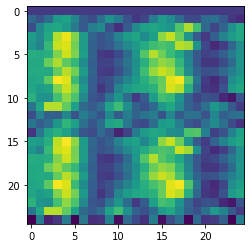

In [16]:
r = sim(**optimizer.max['params'])
plt.imshow(r)